In [6]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
# tumor_areas_train = np.load(f'..\\data\\processed\\tumor_areas_train.npy')
# tumor_areas_val = np.load(f'..\\data\\processed\\tumor_areas_val.npy')
# tumor_areas = np.load(f'..\\data\\processed\\tumor_areas.npy')
# X_features = np.load(f'..\\data\\processed\\X_features.npy')
X_train = np.load(f'..\\data\\processed\\X_train.npy')
X_test = np.load(f'..\\data\\processed\\X_val.npy')
# y_labels = np.load(f'..\\data\\processed\\y_labels.npy')
y_train = np.load(f'..\\data\\processed\\y_train.npy')
y_test = np.load(f'..\\data\\processed\\y_val.npy')

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42))
])

# params to sweep over
param_grid = {
    'svm__C': np.logspace(-2, 2, 10),
    'svm__gamma': np.logspace(-3, 1, 10),
    'svm__kernel': ['rbf']
}

# param_grid = {
#     'C': [0.1, 1, 5, 10, 50, 100],
#     'gamma': ['scale', 0.01, 0.001],
#     'kernel': ['rbf']
# }

# cv here defines 5-fold cross-validation
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=5,  
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

svm_clf = grid_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'svm__C': np.float64(35.93813663804626), 'svm__gamma': np.float64(0.007742636826811269), 'svm__kernel': 'rbf'}
Best cross-validation score: 0.9381566732973383


Test Accuracy: 0.9495
Classification Report on Test Set:
                  precision    recall  f1-score   support

        no_tumor       0.91      0.87      0.89        79
    glioma_tumor       0.95      0.99      0.97       165
meningioma_tumor       0.93      0.92      0.92       165
 pituitary_tumor       0.99      0.98      0.98       165

        accuracy                           0.95       574
       macro avg       0.94      0.94      0.94       574
    weighted avg       0.95      0.95      0.95       574

Confusion Matrix:
[[ 69   0   9   1]
 [  0 163   2   0]
 [  6   7 151   1]
 [  1   1   1 162]]


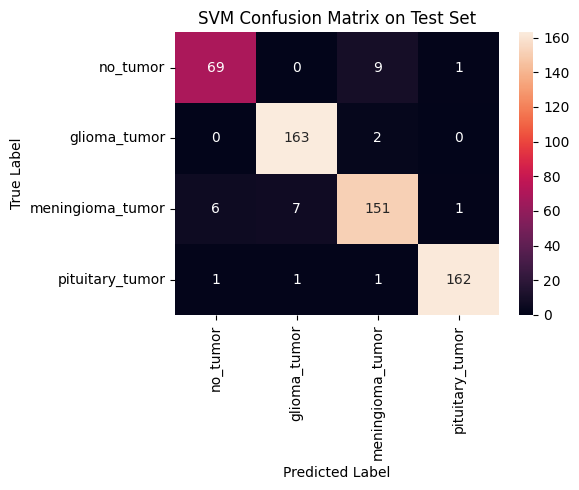

In [9]:
y_pred_test = svm_clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

categories = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test, target_names=categories))

conf_mat = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_mat)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', 
            xticklabels=categories, yticklabels=categories)
plt.title("SVM Confusion Matrix on Test Set")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Inference time for 574 samples: 0.0765 seconds
Average inference time per sample: 0.1333 ms
Model memory usage: 1258604 bytes (~1229.11 KB)


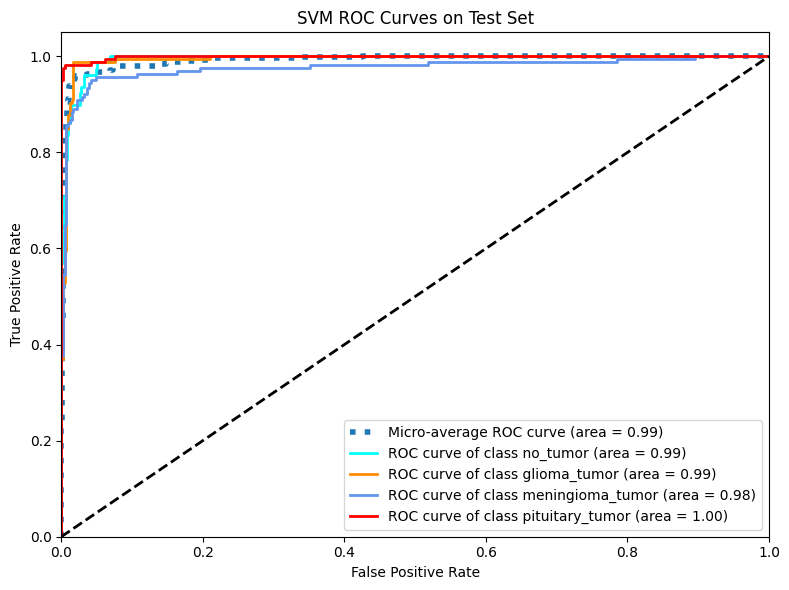

In [10]:
import time
import pickle
import sys
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

start_time = time.time()
y_pred_test = svm_clf.predict(X_test)
end_time = time.time()
total_time = end_time - start_time
avg_inference_time_ms = (total_time / len(X_test)) * 1000  # in milliseconds

print(f"Inference time for {len(X_test)} samples: {total_time:.4f} seconds")
print(f"Average inference time per sample: {avg_inference_time_ms:.4f} ms")

model_bytes = pickle.dumps(svm_clf)
memory_usage_bytes = sys.getsizeof(model_bytes)
memory_usage_kb = memory_usage_bytes / 1024

print(f"Model memory usage: {memory_usage_bytes} bytes (~{memory_usage_kb:.2f} KB)")

categories = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
n_classes = len(categories)

y_test_binarized = label_binarize(y_test, classes=range(n_classes))

try:
    y_score = svm_clf.decision_function(X_test)
except AttributeError:
    y_score = svm_clf.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))

plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (area = {roc_auc['micro']:.2f})",
         linestyle=":", linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {categories[i]} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curves on Test Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
